# First Stab at the IEEE fraud data

The IEEE Fraud data consists of 2 data sets. 
- **train/test_transaction**. Has all of the base attributes of the payments, like the amount, the product details etc...
- **train/test_identity**. Contains identity data, network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. The identity data set is smaller, not all transaction have an identity record, it contains online data, obviously not all transaction have network data available (for instance POS transactions)

Most of the Kaggle competition have left joined the identity to the transactions. We will do something slightly differenlty. In this first notebook we will try to see where we get with the **transaction file only**, this will obviously not get world class results, but just to get a feel. 

The transaction file data has following categories;

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- Card1 - Card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.


A lot of the features in the data set **have missing values**, so we are going to use a lot of embeddings, most fields will be encoded as index (or bin) and turned into an embedding. We suspect embeddings allow the model to better handle missing values and offer a higher level of abstraction. (Making it more difficult to overfit)

Now, the challenge is that this gives us a lot of embeddings. Especially the V (Vesta Rich Features) are very numerous (339 Total!!). Adding them all as embedding would make for a very compute intensive model. From reading some of the content online, they are heavily correlated. Therefore we will first try **without any V-feature** and in the next notebooks try out a couple of ways to include them.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import numpy as np
import pandas as pd
import math
import datetime as dt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple


/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
tr_train_file = '../../../../data/train_transaction.csv'
tr_test_file = '../../../../data/test_transaction.csv'
id_train_file = '../../../../data/train_identity.csv'
id_test_file = '../../../../data/train_identity.csv'

In [5]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def offset_to_datetime(offset: int):
    return dt.datetime(2017, 1, 11) + dt.timedelta(seconds=int(offset))

fraud     = ft.FeatureSource('isFraud', ft.FEATURE_TYPE_INT_8)
dtb       = ft.FeatureSource('TransactionDT', ft.FEATURE_TYPE_INT_32)
date_time = ft.FeatureExpression('date_time', ft.FEATURE_TYPE_DATE_TIME, offset_to_datetime, [dtb])

# Base Categorical features
amount  = ft.FeatureSource('TransactionAmt', ft.FEATURE_TYPE_FLOAT_32)
product = ft.FeatureSource('ProductCD', ft.FEATURE_TYPE_CATEGORICAL)
card1   = ft.FeatureSource('card1', ft.FEATURE_TYPE_CATEGORICAL)
card2   = ft.FeatureSource('card2', ft.FEATURE_TYPE_CATEGORICAL)
card3   = ft.FeatureSource('card3', ft.FEATURE_TYPE_CATEGORICAL)
card4   = ft.FeatureSource('card4', ft.FEATURE_TYPE_CATEGORICAL)
card5   = ft.FeatureSource('card5', ft.FEATURE_TYPE_CATEGORICAL)
card6   = ft.FeatureSource('card6', ft.FEATURE_TYPE_CATEGORICAL)
addr1   = ft.FeatureSource('addr1', ft.FEATURE_TYPE_CATEGORICAL)
addr2   = ft.FeatureSource('addr2', ft.FEATURE_TYPE_CATEGORICAL)
dist1   = ft.FeatureSource('dist1', ft.FEATURE_TYPE_FLOAT_32)
p_mail_dom = ft.FeatureSource('P_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)
r_mail_dom = ft.FeatureSource('R_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)

# Raw count features
c1  = ft.FeatureSource('C1', ft.FEATURE_TYPE_FLOAT_32)
c2  = ft.FeatureSource('C2', ft.FEATURE_TYPE_FLOAT_32)
c3  = ft.FeatureSource('C3', ft.FEATURE_TYPE_FLOAT_32)
c4  = ft.FeatureSource('C4', ft.FEATURE_TYPE_FLOAT_32)
c5  = ft.FeatureSource('C5', ft.FEATURE_TYPE_FLOAT_32)
c6  = ft.FeatureSource('C6', ft.FEATURE_TYPE_FLOAT_32)
c7  = ft.FeatureSource('C7', ft.FEATURE_TYPE_FLOAT_32)
c8  = ft.FeatureSource('C8', ft.FEATURE_TYPE_FLOAT_32)
c9  = ft.FeatureSource('C9', ft.FEATURE_TYPE_FLOAT_32)
c10 = ft.FeatureSource('C10', ft.FEATURE_TYPE_FLOAT_32)
c11 = ft.FeatureSource('C11', ft.FEATURE_TYPE_FLOAT_32)
c12 = ft.FeatureSource('C12', ft.FEATURE_TYPE_FLOAT_32)
c13 = ft.FeatureSource('C13', ft.FEATURE_TYPE_FLOAT_32)
c14 = ft.FeatureSource('C14', ft.FEATURE_TYPE_FLOAT_32)

# Raw distance features.
d1  = ft.FeatureSource('D1', ft.FEATURE_TYPE_FLOAT_32)
d2  = ft.FeatureSource('D2', ft.FEATURE_TYPE_FLOAT_32)
d3  = ft.FeatureSource('D3', ft.FEATURE_TYPE_FLOAT_32)
d4  = ft.FeatureSource('D4', ft.FEATURE_TYPE_FLOAT_32)
d5  = ft.FeatureSource('D5', ft.FEATURE_TYPE_FLOAT_32)
d6  = ft.FeatureSource('D6', ft.FEATURE_TYPE_FLOAT_32)
d7  = ft.FeatureSource('D7', ft.FEATURE_TYPE_FLOAT_32)
d8  = ft.FeatureSource('D8', ft.FEATURE_TYPE_FLOAT_32)
d9  = ft.FeatureSource('D9', ft.FEATURE_TYPE_FLOAT_32)
d10 = ft.FeatureSource('D10', ft.FEATURE_TYPE_FLOAT_32)
d11 = ft.FeatureSource('D11', ft.FEATURE_TYPE_FLOAT_32)
d12 = ft.FeatureSource('D12', ft.FEATURE_TYPE_FLOAT_32)
d13 = ft.FeatureSource('D13', ft.FEATURE_TYPE_FLOAT_32)
d14 = ft.FeatureSource('D14', ft.FEATURE_TYPE_FLOAT_32)
d15 = ft.FeatureSource('D15', ft.FEATURE_TYPE_FLOAT_32)

# Match features.
m1 = ft.FeatureSource('M1', ft.FEATURE_TYPE_CATEGORICAL)
m2 = ft.FeatureSource('M2', ft.FEATURE_TYPE_CATEGORICAL)
m3 = ft.FeatureSource('M3', ft.FEATURE_TYPE_CATEGORICAL)
m4 = ft.FeatureSource('M4', ft.FEATURE_TYPE_CATEGORICAL)
m5 = ft.FeatureSource('M5', ft.FEATURE_TYPE_CATEGORICAL)
m6 = ft.FeatureSource('M6', ft.FEATURE_TYPE_CATEGORICAL)
m7 = ft.FeatureSource('M7', ft.FEATURE_TYPE_CATEGORICAL)
m8 = ft.FeatureSource('M8', ft.FEATURE_TYPE_CATEGORICAL)
m9 = ft.FeatureSource('M9', ft.FEATURE_TYPE_CATEGORICAL)

td = ft.TensorDefinition('transactions', [
    date_time, amount, product, fraud, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, p_mail_dom,
    r_mail_dom, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, d1, d2, d3, d4, d5, d6, d7, d8, d9,
    d10, d11, d12, d13, d14, d15, m1, m2, m3, m4, m5, m6, m7, m8, m9
])

with en.EnginePandas(num_threads=1) as e:
    df = e.df_from_csv(td, tr_train_file, inference=False)

2023-05-24 15:07:51.857 eng1n3.common.engine           INFO     Start Engine...
2023-05-24 15:07:51.857 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-24 15:07:51.858 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-24 15:07:51.858 eng1n3.pandas.pandasengine     INFO     Building Panda for : transactions from file ../../../../data/train_transaction.csv
2023-05-24 15:07:55.995 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: transactions


## Feature Analysis

In [6]:
df

,date_time,TransactionAmt,ProductCD,isFraud,card1,card2,card3,card4,card5,card6,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2017-01-12 00:00:00,68.500000,W,0,13926,NaN,150.0,discover,142.0,credit,...,0.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2017-01-12 00:00:01,29.000000,W,0,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2017-01-12 00:01:09,59.000000,W,0,4663,490.0,150.0,visa,166.0,debit,...,315.0,T,T,T,M0,F,F,F,F,F
3,2017-01-12 00:01:39,50.000000,W,0,18132,567.0,150.0,mastercard,117.0,debit,...,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2017-01-12 00:01:46,50.000000,H,0,4497,514.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2017-07-12 23:57:27,49.000000,W,0,6550,NaN,150.0,visa,226.0,debit,...,56.0,T,T,T,M0,T,F,F,F,T
590536,2017-07-12 23:57:29,39.500000,W,0,10444,225.0,150.0,mastercard,224.0,debit,...,0.0,T,F,F,M0,F,T,F,F,F
590537,2017-07-12 23:57:59,30.950001,W,0,12037,595.0,150.0,mastercard,224.0,debit,...,0.0,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,2017-07-12 23:58:08,117.000000,W,0,7826,481.0,150.0,mastercard,224.0,debit,...,22.0,T,T,T,M0,F,T,NaN,NaN,NaN


### Base Features
Within the base features we have 2 numerical features. Dist is only populated for a bit less than 1/2 of the records. We will use a `FeatureBin` for both. And because from the 75% percentile we see that there are likely outliers (which is confirmed in the histograms). So we will use a 'geometric' scale_type.

In [7]:
df[['TransactionAmt', 'dist1']].describe()

,TransactionAmt,dist1
count,590540.000000,238269.000000
mean,135.027161,118.502197
std,239.162521,371.872009
min,0.251000,0.000000
25%,43.320999,3.000000
50%,68.769001,8.000000
75%,125.000000,24.000000
max,31937.390625,10286.000000


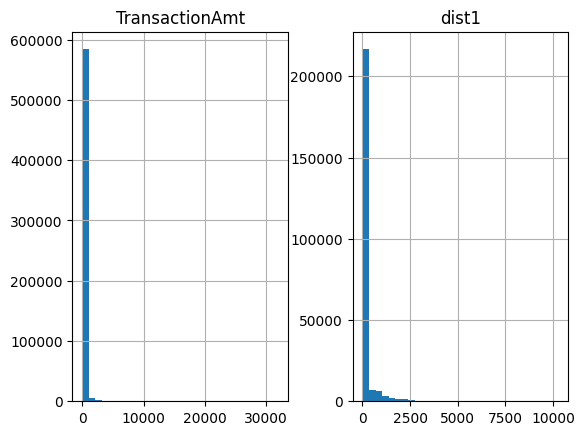

In [8]:
df[['TransactionAmt', 'dist1']].hist(bins=30);

We know from the description that the card fields indicate the card type, country etc... All these fields will be encoded as `FeatureIndex`. 

The card1 feature has a very high cardinality. We'll **drop it** from now, feels like it might make it too easy for our model to identify individual records.

In [9]:
df[
    ['ProductCD'] + [f'card{i}' for i in range (1,6)] + ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
].describe()

,ProductCD,card1,card2,card3,card4,card5,addr1,addr2,P_emaildomain,R_emaildomain
count,590540,590540,581607,588975,588963,586281,524834,524834,496084,137291
unique,5,13553,500,114,4,119,332,74,59,60
top,W,7919,321.0,150.0,visa,226.0,299.0,87.0,gmail.com,gmail.com
freq,439670,14932,48935,521287,384767,296546,46335,520481,228355,57147


In [10]:
# Categorical features.
amount_bin  = ft.FeatureBin('Amount_Bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
dist_bin    = ft.FeatureBin('Dist_Bin', ft.FEATURE_TYPE_INT_8, dist1, 20, scale_type='geometric')
dow         = ft.FeatureDateTimeFormat('day_of_week', ft.FEATURE_TYPE_INT_8, date_time, '%w')
dom         = ft.FeatureDateTimeFormat('day_of_month', ft.FEATURE_TYPE_INT_16, date_time, '%d')
hod         = ft.FeatureDateTimeFormat('hour_of_day', ft.FEATURE_TYPE_INT_16, date_time, '%H')
dow_i       = ft.FeatureIndex('day_of_week_i', ft.FEATURE_TYPE_INT_16, dow)
dom_i       = ft.FeatureIndex('day_of_month_i', ft.FEATURE_TYPE_INT_16, dom)
hod_i       = ft.FeatureIndex('hour_of_day_i', ft.FEATURE_TYPE_INT_16, hod)
product_i   = ft.FeatureIndex('product_i', ft.FEATURE_TYPE_INT_16, product)
card2_i     = ft.FeatureIndex('card2_i', ft.FEATURE_TYPE_INT_16, card2)
card3_i     = ft.FeatureIndex('card3_i', ft.FEATURE_TYPE_INT_16, card3)
card4_i     = ft.FeatureIndex('card4_i', ft.FEATURE_TYPE_INT_16, card4)
card5_i     = ft.FeatureIndex('card5_i', ft.FEATURE_TYPE_INT_16, card5)
card6_i     = ft.FeatureIndex('card6_i', ft.FEATURE_TYPE_INT_16, card6)
addr1_i     = ft.FeatureIndex('addr1_i', ft.FEATURE_TYPE_INT_16, addr1)
addr2_i     = ft.FeatureIndex('addr2_i', ft.FEATURE_TYPE_INT_16, addr2)
p_mail_dom_i = ft.FeatureIndex('P_emaildomain_i', ft.FEATURE_TYPE_INT_16, p_mail_dom)
r_mail_dom_i = ft.FeatureIndex('R_emaildomain_i', ft.FEATURE_TYPE_INT_16, r_mail_dom)

td_categorical = ft.TensorDefinition('ieee-categorical', [
    amount_bin, dist_bin, dow_i, hod_i, product_i, card2_i, card3_i, card4_i, card5_i, card6_i, addr1_i, 
    p_mail_dom_i, r_mail_dom_i
])

### Count Features
The count feature is one of the most conistently available fields. We are definitely going to want to use these. We'll turn them into `FeatureBin` features. If we look at the 75% percentile, and the max, we can see that there might be some outliers, therefore we are going to use a 'geometric' scale.

In [11]:
df[[f'C{i}' for i in range(1,15)]].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144575,4.480240,5.240343,10.241521,4.076227,32.539917,8.295215
std,133.569016,154.668900,0.150536,68.848457,25.786976,71.508469,61.727303,95.378571,16.674896,95.581444,94.336288,86.666222,129.364838,49.544262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,12.000000,2.000000
max,4685.000000,5691.000000,26.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


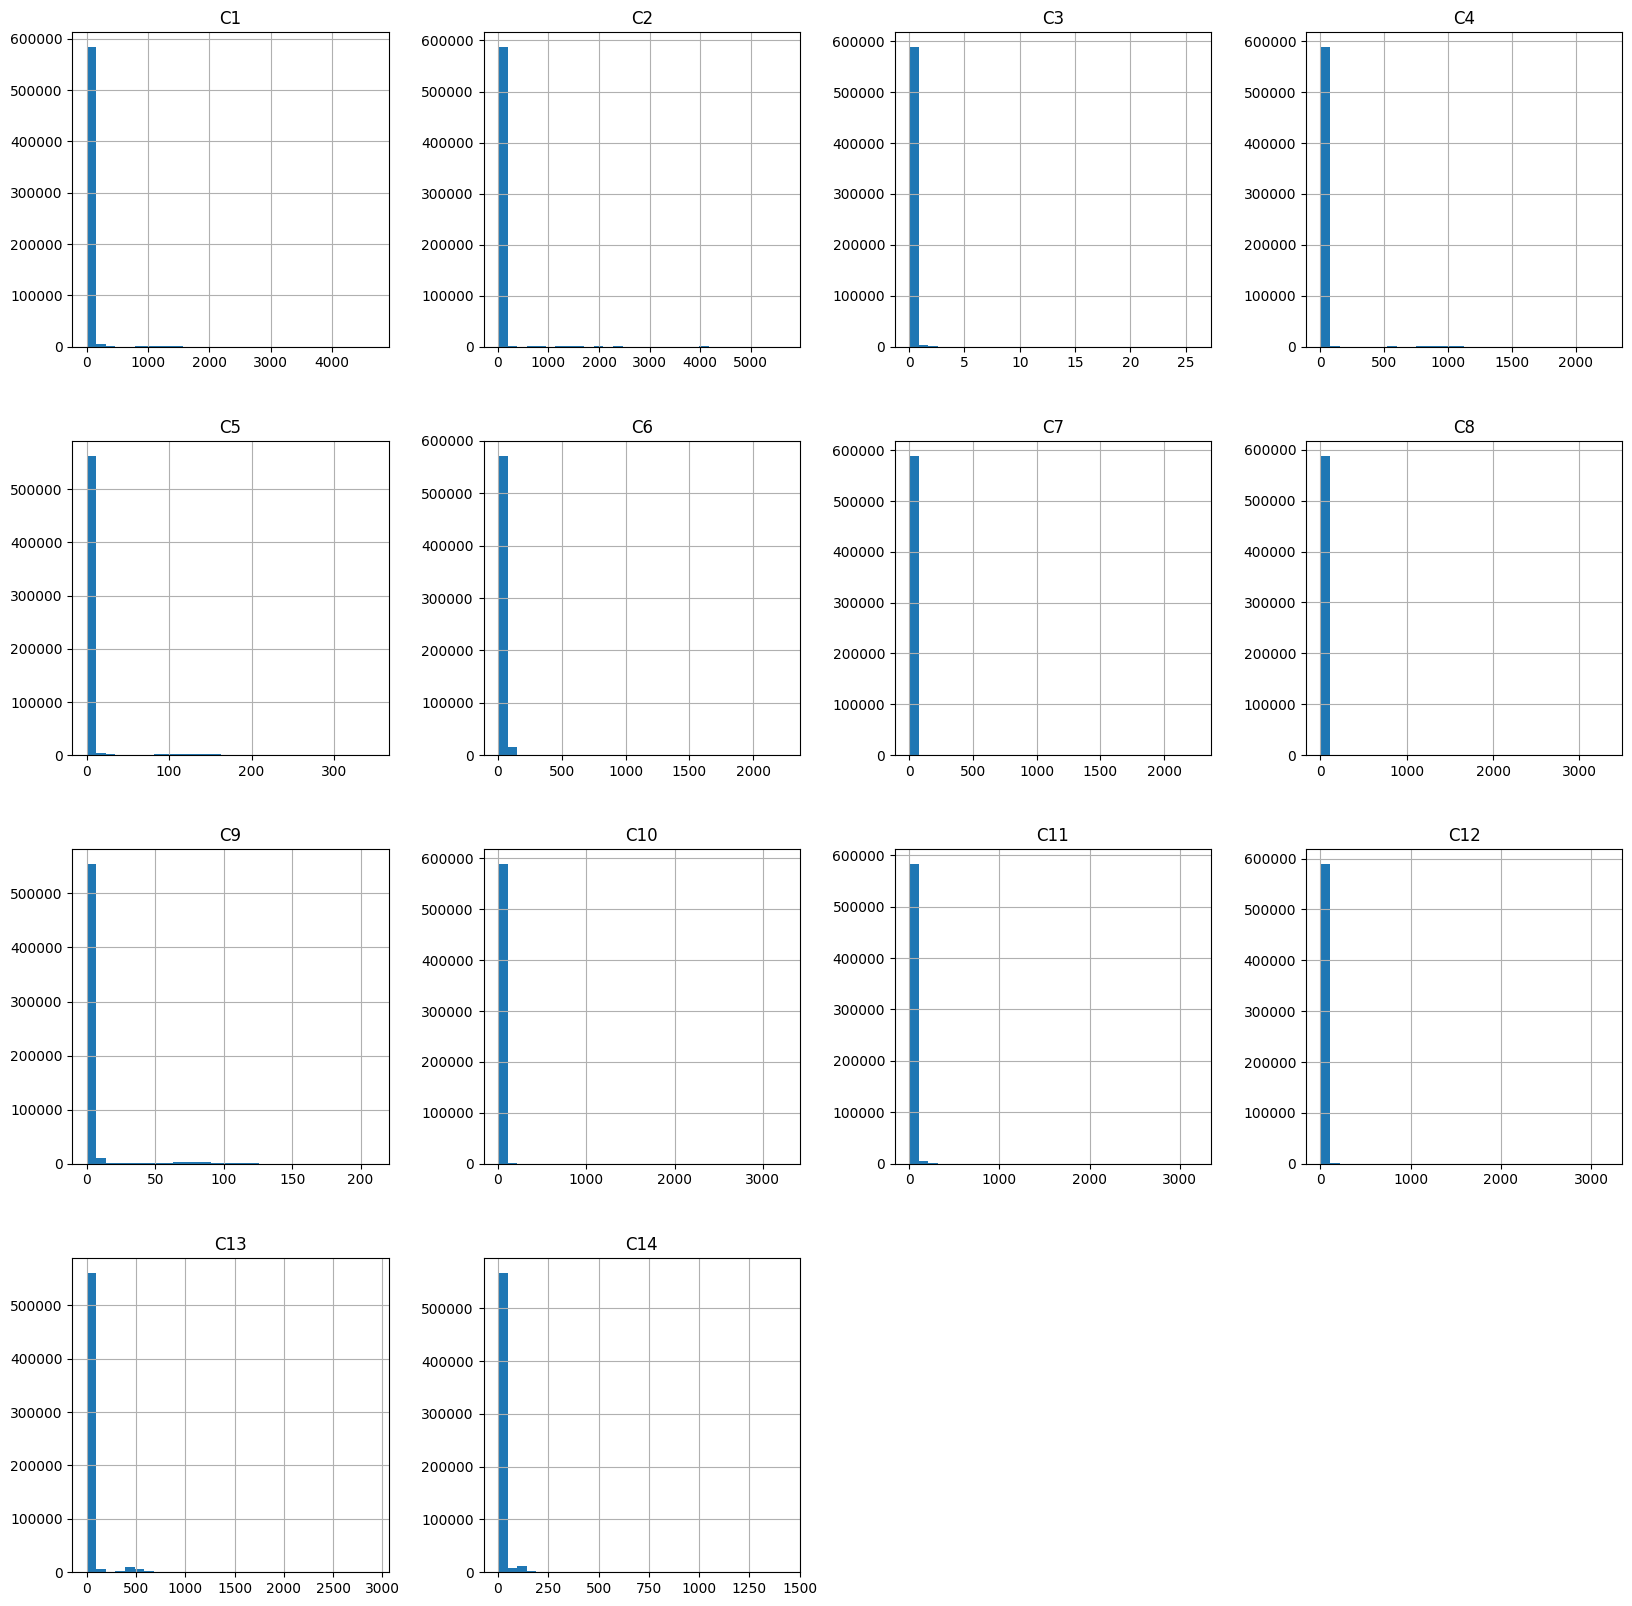

In [12]:
df[[f'C{i}' for i in range(1,15)]].hist(bins=30, figsize=(20,20));

In [13]:
# Count Features
c1_bin     = ft.FeatureBin('C1_Bin', ft.FEATURE_TYPE_INT_8, c1, 20, scale_type='geometric')
c2_bin     = ft.FeatureBin('C2_Bin', ft.FEATURE_TYPE_INT_8, c2, 20, scale_type='geometric')
c4_bin     = ft.FeatureBin('C4_Bin', ft.FEATURE_TYPE_INT_8, c4, 20, scale_type='geometric')
c5_bin     = ft.FeatureBin('C5_Bin', ft.FEATURE_TYPE_INT_8, c5, 20, scale_type='geometric')
c6_bin     = ft.FeatureBin('C6_Bin', ft.FEATURE_TYPE_INT_8, c6, 20, scale_type='geometric')
c7_bin     = ft.FeatureBin('C7_Bin', ft.FEATURE_TYPE_INT_8, c7, 20, scale_type='geometric')
c8_bin     = ft.FeatureBin('C8_Bin', ft.FEATURE_TYPE_INT_8, c8, 20, scale_type='geometric')
c9_bin     = ft.FeatureBin('C9_Bin', ft.FEATURE_TYPE_INT_8, c9, 20, scale_type='geometric')
c10_bin    = ft.FeatureBin('C10_Bin', ft.FEATURE_TYPE_INT_8, c10, 20, scale_type='geometric')
c11_bin    = ft.FeatureBin('C11_Bin', ft.FEATURE_TYPE_INT_8, c11, 20, scale_type='geometric')
c12_bin    = ft.FeatureBin('C12_Bin', ft.FEATURE_TYPE_INT_8, c12, 20, scale_type='geometric')
c13_bin    = ft.FeatureBin('C13_Bin', ft.FEATURE_TYPE_INT_8, c13, 20, scale_type='geometric')
c14_bin    = ft.FeatureBin('C14_Bin', ft.FEATURE_TYPE_INT_8, c14, 20, scale_type='geometric')

# TensorDefinitions
td_counts = ft.TensorDefinition('ieee-counts', [
    c1_bin, c2_bin, c4_bin, c5_bin, c6_bin, c7_bin, c8_bin, c9_bin, c10_bin, 
    c11_bin, c12_bin, c13_bin, c14_bin
])

### TimeDelta Features
Next set of feature are the time-delta features, they are much less available than the previous set, some only have 38k lines with data. We'll use them all as `FeatureBin`. Their distributions are a bit skewed, but we'll use a 'linear' (default) scale-type for the bins.

In [14]:
df[[f'D{i}' for i in range(1,16)]].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000
mean,94.347557,169.563232,28.343348,140.002441,42.335964,69.805717,41.638950,146.058090,0.561057,123.982140,146.621475,54.037533,17.901295,57.724445,163.744568
std,157.660385,177.315872,62.384720,191.096771,89.000145,143.669250,99.743263,231.663849,0.316880,182.615219,186.042618,124.274559,67.614426,136.312454,202.726669
min,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000
25%,0.000000,26.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,97.000000,8.000000,26.000000,10.000000,0.000000,0.000000,37.875000,0.666666,15.000000,43.000000,0.000000,0.000000,0.000000,52.000000
75%,122.000000,276.000000,27.000000,253.000000,32.000000,40.000000,17.000000,187.958328,0.833333,197.000000,274.000000,13.000000,0.000000,2.000000,314.000000
max,640.000000,640.000000,819.000000,869.000000,819.000000,873.000000,843.000000,1707.791626,0.958333,876.000000,670.000000,648.000000,847.000000,878.000000,879.000000


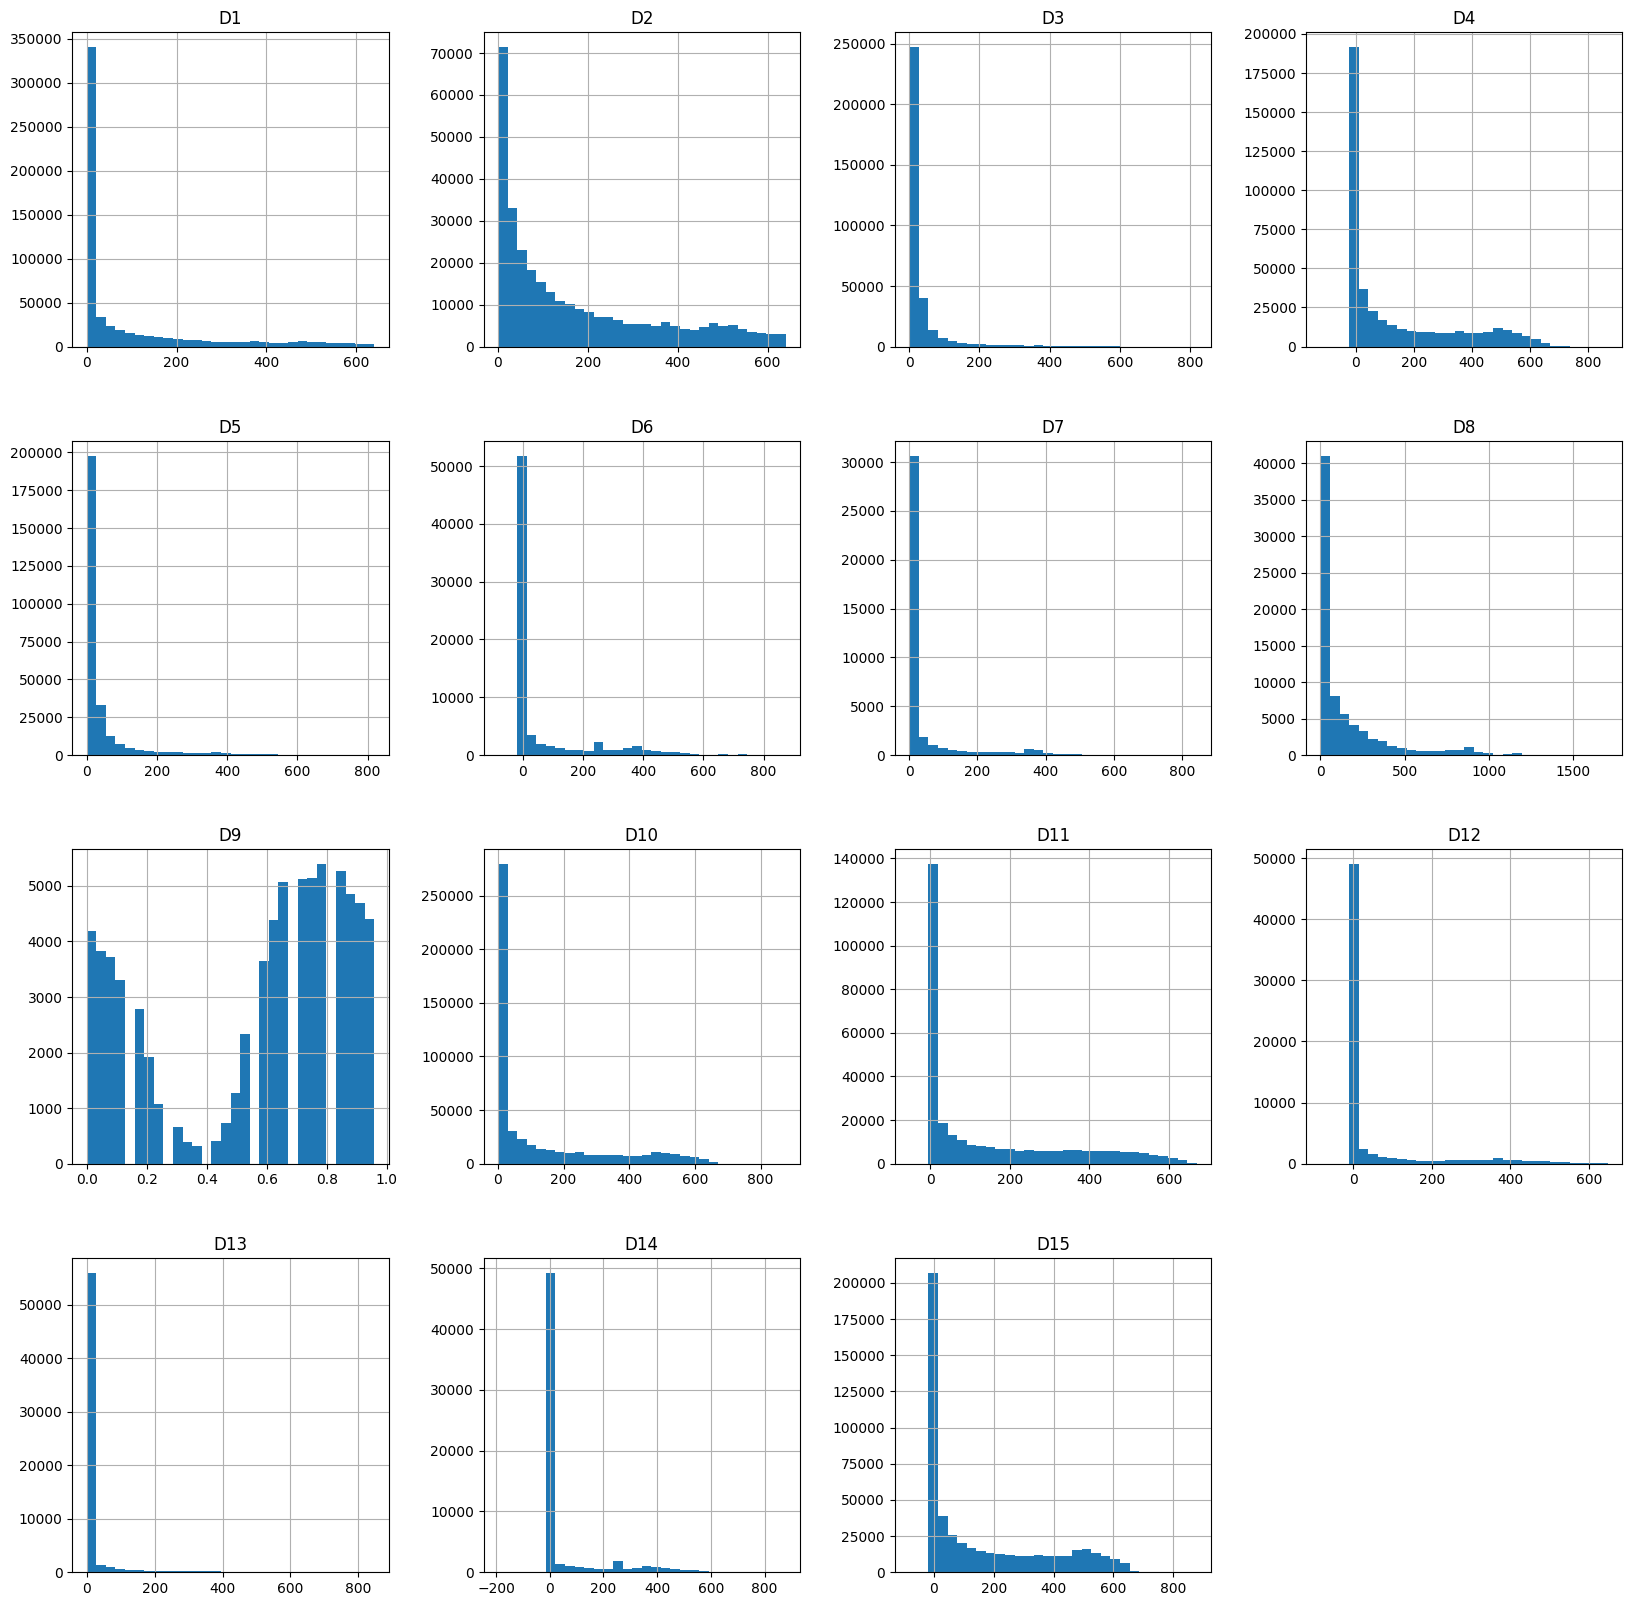

In [15]:
df[[f'D{i}' for i in range(1,16)]].hist(bins=30, figsize=(20,20));

One thing we can observe is that some have negative values. Overall, there is not that many negative value rows (27 rows across all columns), and none is a acutal fraud. We'll convert the negative values to NaN using a `FeatureExpression`.

In [16]:
df[
    (df['D4'] < 0) | (df['D6'] < 0) | (df['D6'] < 0) | (df['D11'] < 0) | (df['D12'] < 0) | 
    (df['D14'] < 0) | (df['D15'] < 0)
]

,date_time,TransactionAmt,ProductCD,isFraud,card1,card2,card3,card4,card5,card6,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
2947,2017-01-12 17:55:46,171.000000,W,0,14086,555.0,150.0,visa,226.0,debit,...,-15.0,T,T,T,M0,F,T,F,F,T
3034,2017-01-12 18:09:37,312.790009,W,0,7919,194.0,150.0,mastercard,166.0,debit,...,-30.0,T,T,T,NaN,NaN,F,T,T,T
3814,2017-01-12 20:15:58,39.000000,W,0,7919,194.0,150.0,mastercard,166.0,debit,...,363.0,T,T,T,M0,F,F,F,F,T
4085,2017-01-12 21:01:01,23.926001,C,0,3874,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
4097,2017-01-12 21:02:08,23.926001,C,0,3874,555.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
4210,2017-01-12 21:17:53,44.000000,W,0,3178,490.0,150.0,visa,226.0,debit,...,298.0,T,T,T,M0,T,F,F,F,T
4932,2017-01-12 23:31:24,58.950001,W,0,14079,360.0,150.0,mastercard,126.0,debit,...,-13.0,T,T,T,NaN,NaN,F,F,T,T
5264,2017-01-13 00:28:32,39.000000,W,0,2616,327.0,150.0,discover,102.0,credit,...,NaN,T,T,T,M0,T,T,T,T,T
5501,2017-01-13 01:13:38,107.667999,C,0,3154,408.0,185.0,mastercard,224.0,debit,...,-83.0,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
6057,2017-01-13 04:47:28,209.949997,W,0,12839,321.0,150.0,visa,226.0,debit,...,-1.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN


In [17]:
# Function to replace a negative number with Nan. For use as FeatureExpression.
def set_negative_to_nan(feature: int):
    return feature if not math.isnan(feature) and feature >= 0 else np.nan

# Timing Features
d1_bin  = ft.FeatureBin('D1_Bin', ft.FEATURE_TYPE_INT_8, d1, 15)
d2_bin  = ft.FeatureBin('D2_Bin', ft.FEATURE_TYPE_INT_8, d2, 15)
d3_bin  = ft.FeatureBin('D3_Bin', ft.FEATURE_TYPE_INT_8, d3, 15)
d4_bin  = ft.FeatureBin('D4_Bin', ft.FEATURE_TYPE_INT_8, d4, 15)
d5_bin  = ft.FeatureBin('D5_Bin', ft.FEATURE_TYPE_INT_8, d5, 15)
d6_ex   = ft.FeatureExpression('d6_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d6])
d6_bin  = ft.FeatureBin('D6_Bin', ft.FEATURE_TYPE_INT_8, d6_ex, 15)
d7_bin  = ft.FeatureBin('D7_Bin', ft.FEATURE_TYPE_INT_8, d7, 15)
d8_bin  = ft.FeatureBin('D8_Bin', ft.FEATURE_TYPE_INT_8, d8, 15)
d9_bin  = ft.FeatureBin('D9_Bin', ft.FEATURE_TYPE_INT_8, d9, 15)
d10_bin = ft.FeatureBin('D10_Bin', ft.FEATURE_TYPE_INT_8, d10, 15)
d11_ex  = ft.FeatureExpression('d11_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d11])
d11_bin = ft.FeatureBin('D11_Bin', ft.FEATURE_TYPE_INT_8, d11_ex, 15)
d12_ex  = ft.FeatureExpression('d12_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d12])
d12_bin = ft.FeatureBin('D12_Bin', ft.FEATURE_TYPE_INT_8, d12_ex, 15)
d13_bin = ft.FeatureBin('D13_Bin', ft.FEATURE_TYPE_INT_8, d13, 15)
d14_ex  = ft.FeatureExpression('d14_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d14])
d14_bin = ft.FeatureBin('D14_Bin', ft.FEATURE_TYPE_INT_8, d14_ex, 15)
d15_ex  = ft.FeatureExpression('d15_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d15])
d15_bin = ft.FeatureBin('D15_Bin', ft.FEATURE_TYPE_INT_8, d15_ex, 15)

td_timing = ft.TensorDefinition('ieee-timing', [
    d1_bin, d2_bin, d3_bin, d4_bin, d5_bin, d6_bin, d7_bin, d8_bin, d9_bin, d10_bin, 
    d11_bin, d12_bin, d13_bin, d14_bin, d15_bin
])

### Match Columns Features

All the match columns have a very low cardinality, they are fairly well populated, they will all be encoded as `FeatureIndex`.

In [18]:
df[[f'M{i}' for i in range(1,10)]].describe()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,319415,285468,251731,196405,132491,227856,211374,155251,205656


In [19]:
# Match features
m1_i = ft.FeatureIndex('m1_i', ft.FEATURE_TYPE_INT_8, m1)
m2_i = ft.FeatureIndex('m2_i', ft.FEATURE_TYPE_INT_8, m2)
m3_i = ft.FeatureIndex('m3_i', ft.FEATURE_TYPE_INT_8, m3)
m4_i = ft.FeatureIndex('m4_i', ft.FEATURE_TYPE_INT_8, m4)
m5_i = ft.FeatureIndex('m5_i', ft.FEATURE_TYPE_INT_8, m5)
m6_i = ft.FeatureIndex('m6_i', ft.FEATURE_TYPE_INT_8, m6)
m7_i = ft.FeatureIndex('m7_i', ft.FEATURE_TYPE_INT_8, m7)
m8_i = ft.FeatureIndex('m8_i', ft.FEATURE_TYPE_INT_8, m8)
m9_i = ft.FeatureIndex('m9_i', ft.FEATURE_TYPE_INT_8, m9)

td_match = ft.TensorDefinition('ieee-match', [m1_i, m2_i, m3_i, m4_i, m5_i, m6_i, m7_i, m8_i, m9_i])

In [20]:
## Free up memory
del df
_ = gc.collect()

## Create Data-sets and loaders

In [21]:
# Label Feature
fraud_label = ft.FeatureLabelBinary('Fraud_label', ft.FEATURE_TYPE_INT_8, fraud)
td_label = ft.TensorDefinition('ieee-label', [fraud_label])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv(
        (td_categorical, td_counts, td_timing, td_match, td_label), 
        tr_train_file, inference=False
    )

2023-05-24 15:09:12.807 eng1n3.common.engine           INFO     Start Engine...
2023-05-24 15:09:12.807 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-24 15:09:12.808 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-24 15:09:12.808 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv
2023-05-24 15:09:20.343 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-24 15:09:20.355 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 5 numpy arrays


In [22]:
ti[0]

TensorInstance with shapes: ((1, 13), (1, 13), (1, 15), (1, 9), (1, 1))

In [23]:
train, val, test = ti.split_sequential(100000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)

## Create Model

In [24]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(max_dims=30)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(128,64,64,32), dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a 'IEEEFeedForwardModel' instance
model = IEEEFeedForwardModel(mc)
model

IEEEFeedForwardModel(
  Number of parameters : 122110. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=ieee-categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(20, 10)
          (2): Embedding(8, 5)
          (3): Embedding(25, 12)
          (4): Embedding(6, 5)
          (5): Embedding(501, 30)
          (6): Embedding(115, 30)
          (7): Embedding(5, 5)
          (8): Embedding(120, 30)
          (9): Embedding(5, 5)
          (10): Embedding(333, 30)
          (11): Embedding(60, 30)
          (12): Embedding(61, 30)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(
      Name=ieee-counts, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0-12): 13 x Embedding(20, 10)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
 

### Find a good learning rate

Finding LR in 300 steps: 100%|██████████| 300/300 [00:02<00:00, 130.85it/s]                                                    


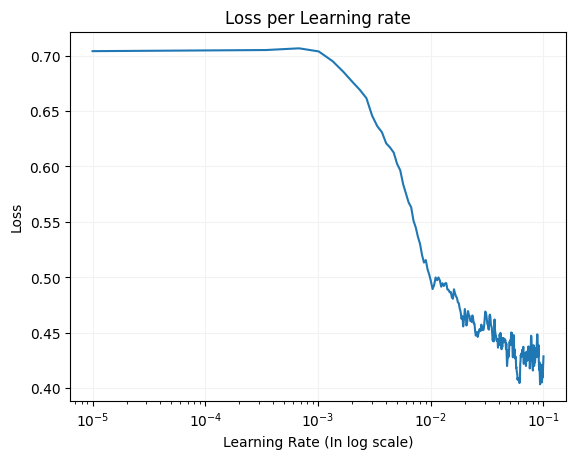

In [25]:
min_lr = 1e-5
max_lr = 1e-1
m_lr = IEEEFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, data_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 300)
mplt.TrainPlot.plot_lr(lrs);

## Train

In [26]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=3e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4615/4615 [00:17<00:00, 262.90it/s, t_loss=0.0899, t_acc=0.965, v_loss=0.198, v_acc=0.941]     


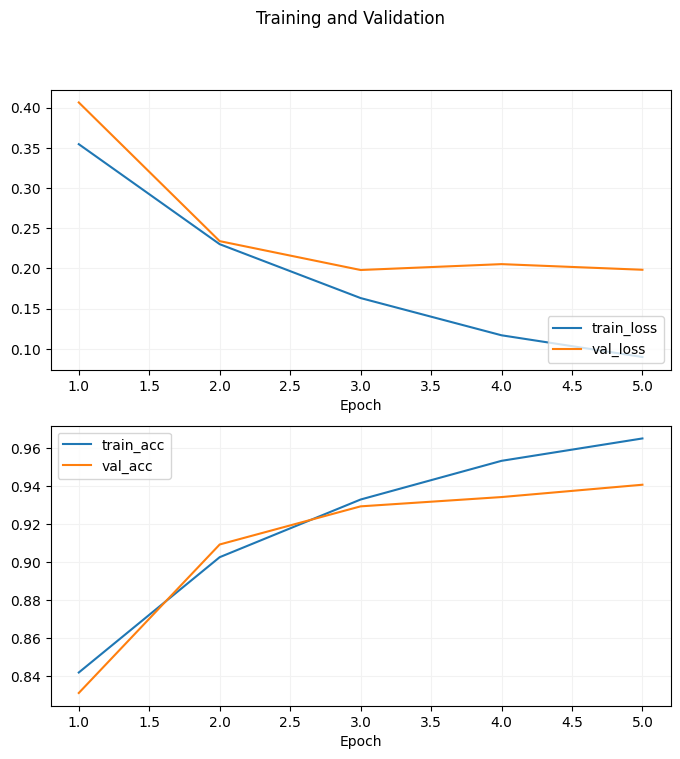

In [27]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Test Model
There is a test file in the competition data, for submissions. Obviously this data does not have the labels. For now we will use to **validation file** to get an initial feel for the performance of our model. 

Testing in 782 steps: 100%|██████████████████| 782/782 [00:01<00:00, 542.45it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     96566
         1.0       0.31      0.61      0.41      3434

    accuracy                           0.94    100000
   macro avg       0.65      0.78      0.69    100000
weighted avg       0.96      0.94      0.95    100000


auc score : 0.8841
ap score  : 0.4682
-----------------------------------------------------


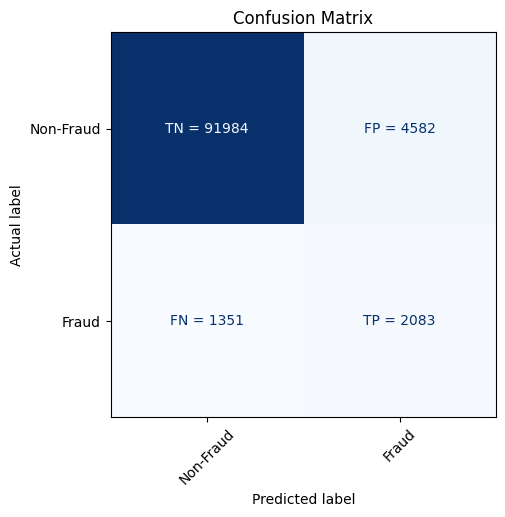

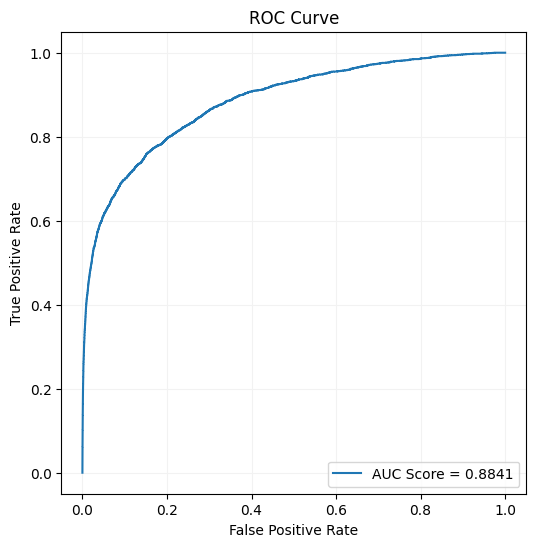

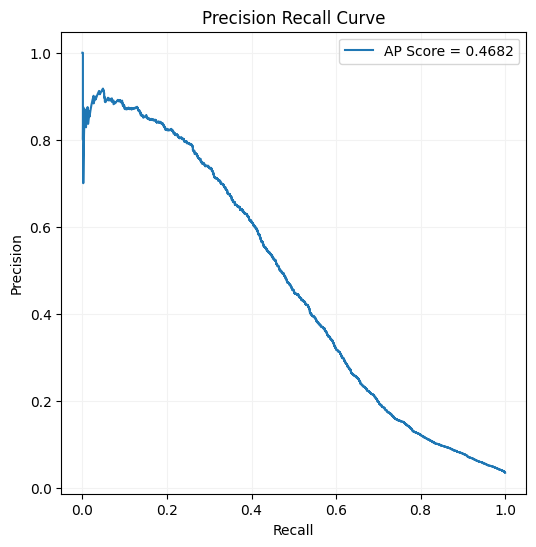

In [29]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

## Plot feature Attribution
These cells will call captum for the first 10.000 records of the **validation** file. After some tinkering, we found that the C3 feature really does not contribute at all. So we removed it. The M1 feature does not seem to contribute a lot either, but weirdly enough the model seems to work better if you leave it in.

In [30]:
attr = cp.CaptumAttributions.get_attributions_binary(
    model, ti.target_tensor_def, model_device, IntegratedGradients, val_ds[:10000]
    #model, ti.target_tensor_def, model_device, IntegratedGradients, val_ds[10000:20000]
)

/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


### Overview

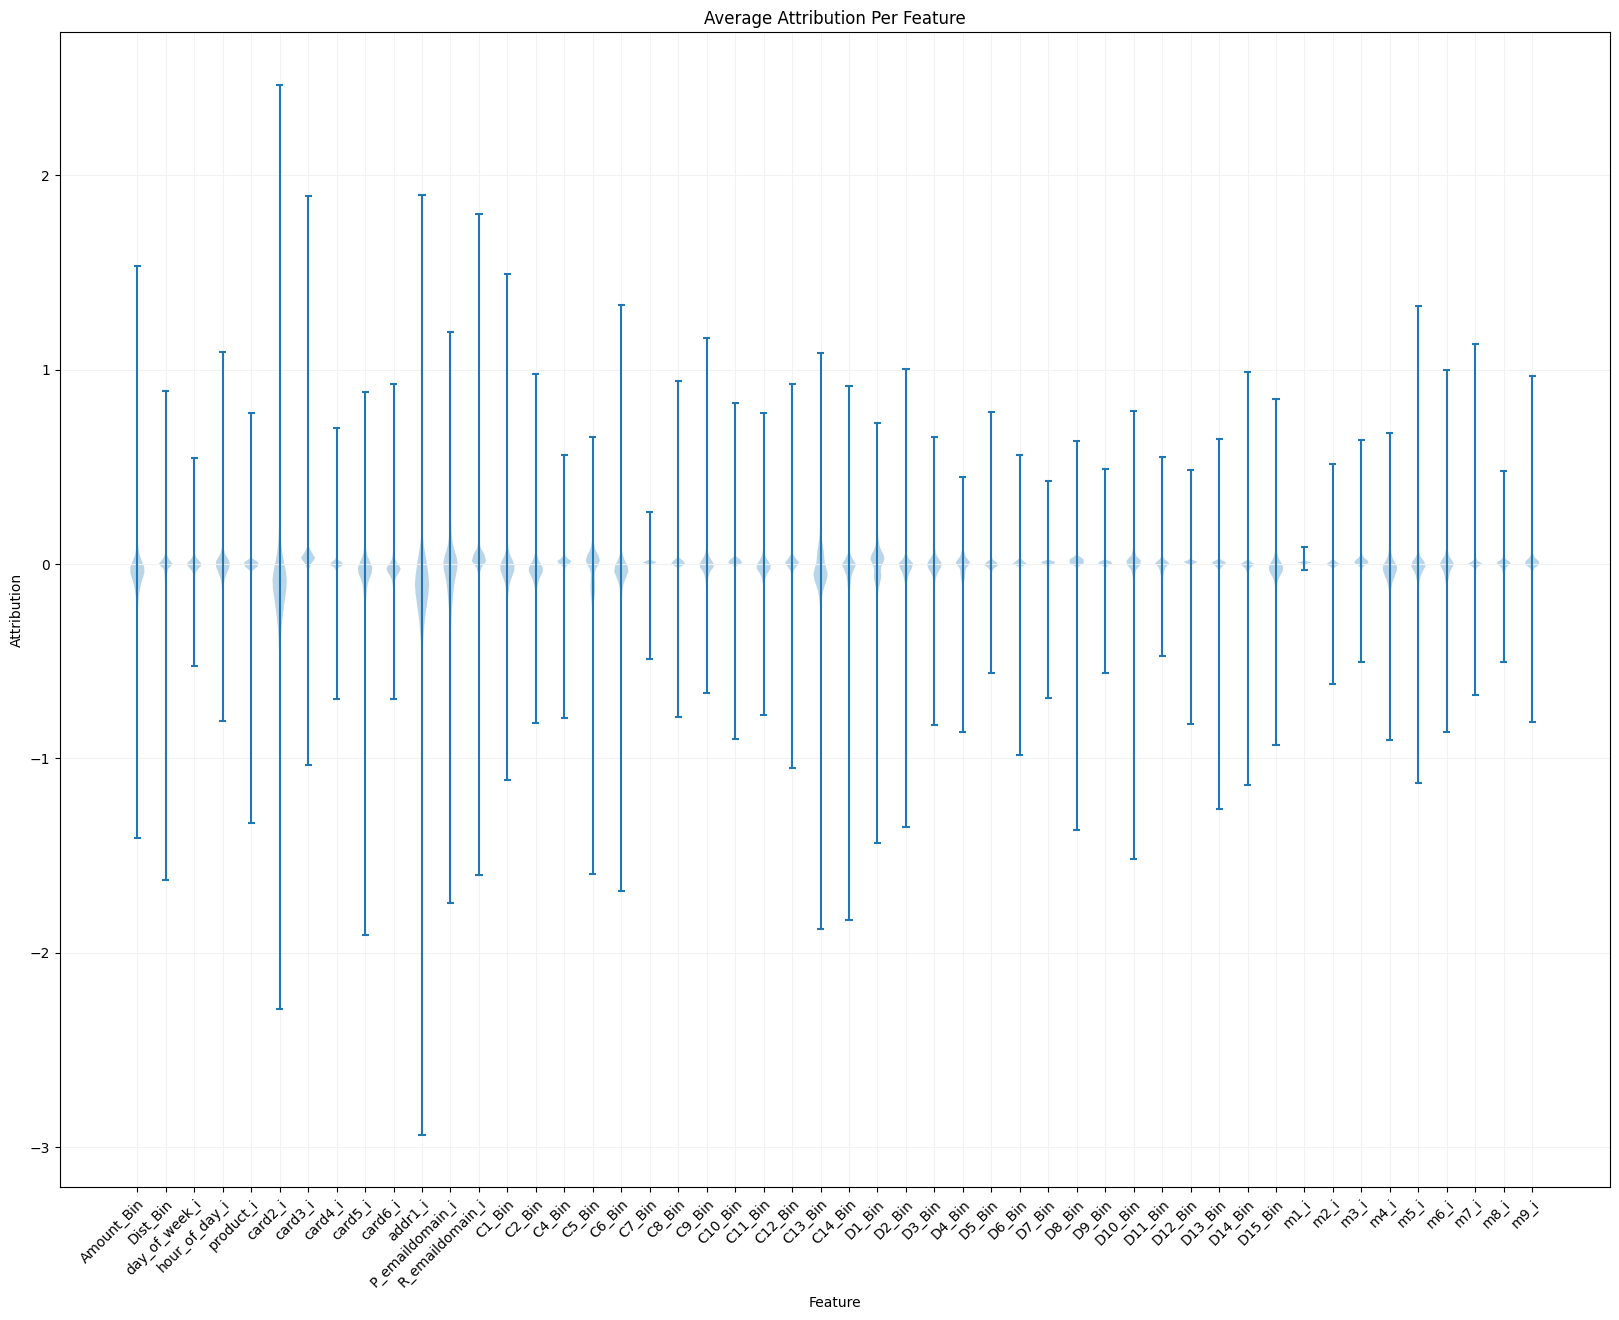

In [31]:
mplt.AttributionPlotBinary.overview(attr, fig_size=(20,15))

### Amount

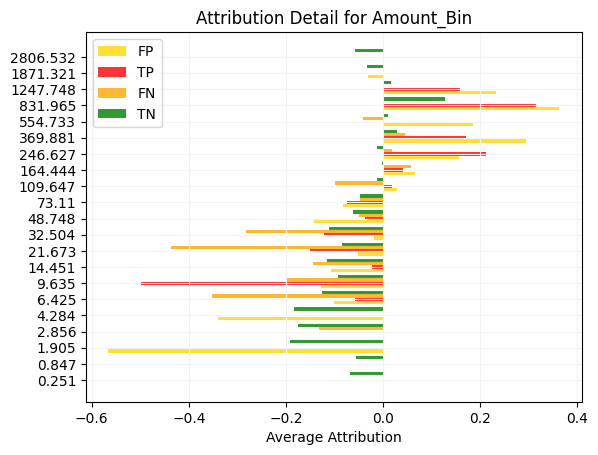

In [32]:
mplt.AttributionPlotBinary.feature_detail(attr, amount_bin)

## Conclusion
We'll leave it at this, it gives us a general feel for the initial data. Next up is checking if the V-Features make our model more powerful. We'll have to be smart about it, there is a massive amount of them and reading the comment on Kaggle, it does not feel like they add a lot to the model.

This model is getting an approx 0.884 AUC on the validation file, not world-class, but we're not using the identity file yet.